In [16]:
import pandas as pd
import zipfile

In [176]:
with zipfile.ZipFile("crashes.csv.zip") as z1:
    with z1.open("crashes.csv") as crashes:
        df_crashes = pd.read_csv(crashes)

df_crashes.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,JC199149,NaN,03/25/2019 02:43:00 PM,30.0,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,...,0.0,1.0,2.0,0.0,14.0,2.0,3.0,41.884547,-87.641201,POINT (-87.64120093714 41.884547224337)
1,792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...,JB422857,NaN,09/05/2018 08:40:00 AM,30.0,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,...,0.0,0.0,2.0,0.0,8.0,4.0,9.0,41.968562,-87.740659,POINT (-87.740659314632 41.968562453871)
2,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,JF318029,NaN,07/15/2022 12:45:00 AM,30.0,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,...,0.0,0.0,2.0,0.0,0.0,6.0,7.0,41.886336,-87.716203,POINT (-87.716203130599 41.886336409761)
3,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,JF324552,NaN,07/15/2022 06:50:00 PM,30.0,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,2.0,0.0,18.0,6.0,7.0,41.925111,-87.667997,POINT (-87.667997321599 41.925110815832)
4,78eee027ec3dcc85d36c9e3fdae4729dcc56440105d65b...,JB291672,NaN,06/03/2018 05:00:00 PM,30.0,NO CONTROLS,NO CONTROLS,CLEAR,UNKNOWN,PARKED MOTOR VEHICLE,...,0.0,0.0,1.0,0.0,17.0,1.0,6.0,41.910758,-87.731389,POINT (-87.731388754145 41.910757551599)


In [177]:
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416872 entries, 0 to 416871
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                416872 non-null  object 
 1   RD_NO                          416813 non-null  object 
 2   CRASH_DATE_EST_I               31821 non-null   object 
 3   CRASH_DATE                     416868 non-null  object 
 4   POSTED_SPEED_LIMIT             416868 non-null  float64
 5   TRAFFIC_CONTROL_DEVICE         416868 non-null  object 
 6   DEVICE_CONDITION               416868 non-null  object 
 7   WEATHER_CONDITION              416868 non-null  object 
 8   LIGHTING_CONDITION             416868 non-null  object 
 9   FIRST_CRASH_TYPE               416867 non-null  object 
 10  TRAFFICWAY_TYPE                416867 non-null  object 
 11  LANE_CNT                       126015 non-null  float64
 12  ALIGNMENT                     

## Feature Engineering

#### `MOST_SEVERE_INJURY` column

In [178]:
df_crashes["MOST_SEVERE_INJURY"].value_counts()

MOST_SEVERE_INJURY
NO INDICATION OF INJURY     359916
NONINCAPACITATING INJURY     31551
REPORTED, NOT EVIDENT        16985
INCAPACITATING INJURY         7039
FATAL                          464
Name: count, dtype: int64

In [179]:
df_crashes["MOST_SEVERE_INJURY"].isna().sum()

917

In [180]:
df_crashes = df_crashes.loc[df_crashes["MOST_SEVERE_INJURY"].notna()]
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415955 entries, 0 to 416866
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                415955 non-null  object 
 1   RD_NO                          415900 non-null  object 
 2   CRASH_DATE_EST_I               31625 non-null   object 
 3   CRASH_DATE                     415955 non-null  object 
 4   POSTED_SPEED_LIMIT             415955 non-null  float64
 5   TRAFFIC_CONTROL_DEVICE         415955 non-null  object 
 6   DEVICE_CONDITION               415955 non-null  object 
 7   WEATHER_CONDITION              415955 non-null  object 
 8   LIGHTING_CONDITION             415955 non-null  object 
 9   FIRST_CRASH_TYPE               415955 non-null  object 
 10  TRAFFICWAY_TYPE                415955 non-null  object 
 11  LANE_CNT                       125779 non-null  float64
 12  ALIGNMENT                      4159

In [181]:
injury_binary = {'NO INDICATION OF INJURY': 0, 'NONINCAPACITATING INJURY': 1, 'REPORTED, NOT EVIDENT': 1, 'INCAPACITATING INJURY': 1, 'FATAL': 1}

df_crashes["MOST_SEVERE_INJURY"] = df_crashes["MOST_SEVERE_INJURY"].map(injury_binary)
df_crashes["MOST_SEVERE_INJURY"].value_counts()

MOST_SEVERE_INJURY
0    359916
1     56039
Name: count, dtype: int64

#### Selecting relavent columns for our analyses

For the first responders, we would like to evaluate the relationship between various factors in car crashes in Chicago and the injuries resulting from the car crashes. Largely, these factors include: **weather condition, time of the crashes, and severity of the damage to the car**.

In [182]:
col_names = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 'DAMAGE', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'MOST_SEVERE_INJURY']

df_crashes = df_crashes[col_names]
df_crashes.info()

#### Checking for missing values

In [184]:
df_crashes.isna().sum()

WEATHER_CONDITION       0
LIGHTING_CONDITION      0
ROADWAY_SURFACE_COND    0
DAMAGE                  0
CRASH_HOUR              0
CRASH_DAY_OF_WEEK       0
CRASH_MONTH             0
MOST_SEVERE_INJURY      0
dtype: int64

## Looking at each column

#### `WEATHER_CONDITION`

In [201]:
df_crashes['WEATHER_CONDITION'].value_counts()

WEATHER_CONDITION
CLEAR                       329357
RAIN                         35894
UNKNOWN                      20048
SNOW                         15007
CLOUDY/OVERCAST              12361
OTHER                         1290
FREEZING RAIN/DRIZZLE          632
FOG/SMOKE/HAZE                 567
SLEET/HAIL                     533
BLOWING SNOW                   195
SEVERE CROSS WIND GATE          69
BLOWING SAND, SOIL, DIRT         2
Name: count, dtype: int64

#### `LIGHTING_CONDITION`

In [202]:
df_crashes['LIGHTING_CONDITION'].value_counts()

LIGHTING_CONDITION
DAYLIGHT                  269941
DARKNESS, LIGHTED ROAD     90476
DARKNESS                   19739
UNKNOWN                    16719
DUSK                       12039
DAWN                        7041
Name: count, dtype: int64

#### `ROADWAY_SURFACE_COND`

In [203]:
df_crashes['ROADWAY_SURFACE_COND'].value_counts()

ROADWAY_SURFACE_COND
DRY                310572
WET                 54892
UNKNOWN             30879
SNOW OR SLUSH       15436
ICE                  3034
OTHER                 997
SAND, MUD, DIRT       145
Name: count, dtype: int64

#### `DAMAGE`

In [204]:
df_crashes['DAMAGE'].value_counts()

DAMAGE
OVER $1,500      250110
$501 - $1,500    116332
$500 OR LESS      49513
Name: count, dtype: int64

#### `CRASH_HOUR`

In [210]:
df_crashes['CRASH_HOUR'].value_counts()

CRASH_HOUR
16.0    31845
15.0    31760
17.0    31193
14.0    28109
18.0    25742
13.0    25377
12.0    24705
8.0     21544
11.0    21258
9.0     19176
10.0    19034
19.0    18809
7.0     17410
20.0    15205
21.0    13693
22.0    12535
23.0    10830
6.0      9105
0.0      8817
1.0      7568
2.0      6521
5.0      5695
3.0      5245
4.0      4779
Name: count, dtype: int64

In [ ]:
grouped_crashes = df_crashes.groupby(['MOST_SEVERE_INJURY'])

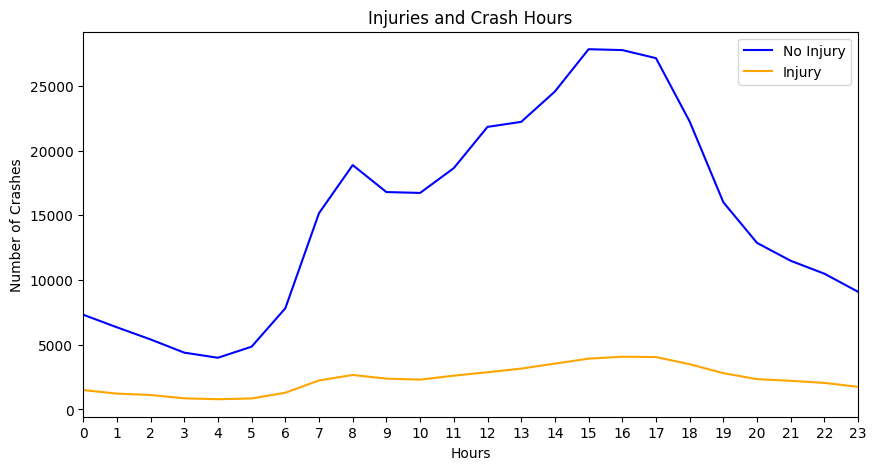

In [219]:
# A line graph of No Injury/Injury on Crash Hours
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
x_no_injury = grouped_crashes.get_group(0)['CRASH_HOUR'].value_counts().sort_index().index
y_no_injury = grouped_crashes.get_group(0)['CRASH_HOUR'].value_counts().sort_index().values
ax.plot(x_no_injury, y_no_injury, 'b', label='No Injury')

x_injury = grouped_crashes.get_group(1)['CRASH_HOUR'].value_counts().sort_index().index
y_injury = grouped_crashes.get_group(1)['CRASH_HOUR'].value_counts().sort_index().values
ax.plot(x_injury, y_injury, 'orange', label='Injury')

ax.set_title("Injuries and Crash Hours")
ax.set_xlabel("Hours")
ax.set_ylabel("Number of Crashes")
ax.set_xticks(range(0,25))
plt.margins(x=0)
ax.legend()

# Potentially, this may be interesting
# It seems more injuries resulting from car crashes occur between 3-5 pm
# Rather than night time or rush hour

#### `CRASH_DAY_OF_WEEK`

In [206]:
df_crashes["CRASH_DAY_OF_WEEK"].value_counts()

CRASH_DAY_OF_WEEK
6.0    67780
7.0    62321
3.0    59536
5.0    59323
4.0    58438
2.0    57611
1.0    50946
Name: count, dtype: int64

#### `CRASH_MONTH`

In [208]:
df_crashes["CRASH_MONTH"].value_counts()

CRASH_MONTH
8.0     40222
7.0     39026
6.0     36839
10.0    36621
5.0     35874
9.0     34752
12.0    33649
11.0    33147
1.0     31914
3.0     31782
2.0     31407
4.0     30722
Name: count, dtype: int64

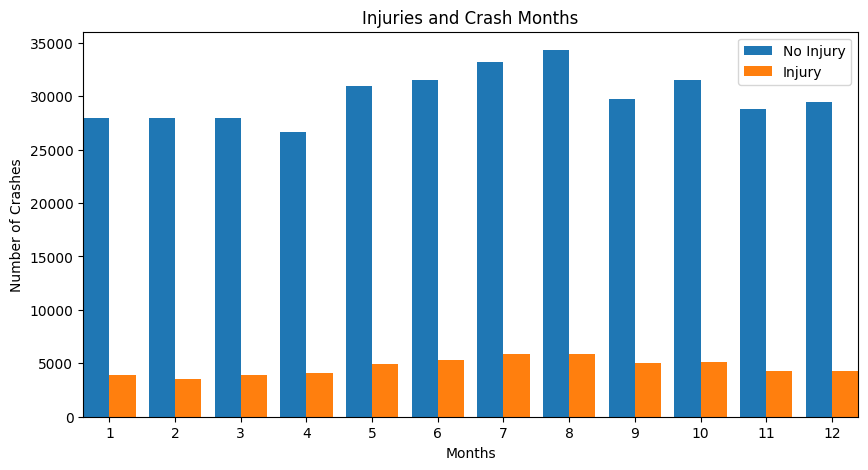

In [279]:
# A Grouped bar graph on No Injury/Injury and Crash Months

fig, ax = plt.subplots(figsize=(10,5))
x_no_injury = grouped_crashes.get_group(0)['CRASH_MONTH'].value_counts().sort_index().index
y_no_injury = grouped_crashes.get_group(0)['CRASH_MONTH'].value_counts().sort_index().values
ax.bar(x_no_injury -0.2, y_no_injury, 0.4, label='No Injury')

x_injury = grouped_crashes.get_group(1)['CRASH_MONTH'].value_counts().sort_index().index
y_injury = grouped_crashes.get_group(1)['CRASH_MONTH'].value_counts().sort_index().values
ax.bar(x_injury + 0.2, y_injury + 0.4, 0.4, label='Injury')

ax.set_xticks(range(1,13))

ax.set_title("Injuries and Crash Months")
ax.set_xlabel("Months")
ax.set_ylabel("Number of Crashes")

plt.margins(x=0)
ax.legend()

# I would have guessed more crashes during the winter months
# But there seems to be no dramatic differences between months

### Attempt to run Dummy Classifier Model

Baseline model to pick the most frequent category. Good to compare with other models later on.

In [185]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

X = df_crashes.drop("MOST_SEVERE_INJURY", axis=1)
y = df_crashes.MOST_SEVERE_INJURY
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [186]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy_clf = dummy_clf.predict(X_test)


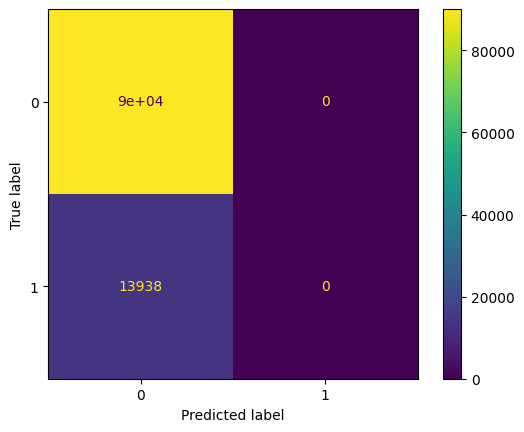

In [187]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm_dummy_clf = confusion_matrix(y_test, y_pred_dummy_clf)
disp = ConfusionMatrixDisplay(cm_dummy_clf)
disp.plot()

### Attempt to run Decision Tree Classifier

It needs numeric values for X's, and no null values.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

In [188]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)


ValueError: could not convert string to float: 'CLOUDY/OVERCAST'

In [85]:
y_pred = dt.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

f, ax = plt.subplots(figsize=(100,100))
plot_tree(dt, ax=ax)

[Text(0.5, 0.9166666666666666, 'x[0] <= 18.5\ngini = 0.244\nsamples = 311966\nvalue = [355, 5277, 269865, 23715, 12754]'),
 Text(0.25, 0.75, 'x[0] <= 5.5\ngini = 0.236\nsamples = 258689\nvalue = [256, 4105, 224993, 18852, 10483]'),
 Text(0.125, 0.5833333333333334, 'x[1] <= 3.5\ngini = 0.287\nsamples = 29163\nvalue = [109, 756, 24426, 2843, 1029]'),
 Text(0.0625, 0.4166666666666667, 'x[1] <= 2.5\ngini = 0.249\nsamples = 6449\nvalue = [21, 141, 5558, 526, 203]'),
 Text(0.03125, 0.25, 'x[0] <= 3.5\ngini = 0.239\nsamples = 4289\nvalue = [12, 86, 3723, 330, 138]'),
 Text(0.015625, 0.08333333333333333, 'gini = 0.234\nsamples = 2974\nvalue = [9, 52, 2590, 232, 91]'),
 Text(0.046875, 0.08333333333333333, 'gini = 0.25\nsamples = 1315\nvalue = [3, 34, 1133, 98, 47]'),
 Text(0.09375, 0.25, 'x[0] <= 1.5\ngini = 0.268\nsamples = 2160\nvalue = [9, 55, 1835, 196, 65]'),
 Text(0.078125, 0.08333333333333333, 'gini = 0.269\nsamples = 903\nvalue = [3, 25, 766, 91, 18]'),
 Text(0.109375, 0.083333333333333

In [86]:
for fi, feature in zip(dt.feature_importances_, dt.feature_names_in_):
    print(fi, feature)

0.6587525358878484 CRASH_HOUR
0.34124746411215146 CRASH_MONTH
